In [1]:
import re
import ast
import emot
import nltk
import string
import pycountry
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/hosseinhimself/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hosseinhimself/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def replace_emoji(text):
    emot_obj = emot.core.emot()
    emotes = emot_obj.emoji(text)
    for i in range(len(emotes['value'])):
        text = text.replace(emotes['value'][i], emotes['mean'][i])
    return text


def normalize(text):
    link_pattern = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    text = re.sub(link_pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = replace_emoji(text)
    text = text.replace('\n',' ')
    return text


In [4]:
data = pd.read_csv("twitter-scraper/scraped_tweets_missingbaby.csv")
tweets = data['text']

In [5]:
data.head()

,Unnamed: 0,username,description,location,following,followers,totaltweets,retweetcount,link,text,hashtags
0,0,JISTLAB_,⛅️ 🇨🇦🇲🇦 IG ~ JISTLAB,"Montréal, Québec",160,135,48087,22,https://twitter.com/i/web/status/1632739441830...,"Runaway British Mum, Constance Marten, Charged...",[]
1,1,Abdul42920472,NaN,NaN,68,2,310,26,https://twitter.com/i/web/status/1632735132611...,Detectives continue to quiz Constance Marten a...,[]
2,2,VaclavusU,"US,UK,World Politics,ShowBiz,Sport Celebrities...","SE 256th street Kent, WA, USA",54,17,24121,0,https://twitter.com/i/web/status/1632731896047...,Constance Marten and Mark Gordon blow each oth...,[]
3,3,VaclavusU,"US,UK,World Politics,ShowBiz,Sport Celebrities...","SE 256th street Kent, WA, USA",54,17,24121,0,https://twitter.com/i/web/status/1632731355392...,Constance Marten and Mark Gordon named baby be...,[]
4,4,colinwitcher,Barrister specialising in General Crime and Bu...,"London, England",1649,2524,2234,1,https://twitter.com/i/web/status/1632721208163...,Lewis Power KC and @colinwitcher instructed on...,[]


In [6]:
print(f'{len(data.index)} tweets about missing baby news.')

9801 tweets about missing baby news.


In [7]:
analyzer = SentimentIntensityAnalyzer()

# Define a dictionary to map the sentiment scores to emotions
emotion_dict = {'angry':0,
               'upset': 0,
               'netural':0,
               'curious':0,
               'happy':0}

all_scores = []

# Loop through each tweet and determine the emotion
for tweet in tweets:
    # Get the sentiment score for the tweet
    sentiment_score = analyzer.polarity_scores(normalize(tweet))
    all_scores.append(sentiment_score)
    # Determine the emotion based on the sentiment score
    
    if sentiment_score['neg'] > sentiment_score['pos']:
        if sentiment_score['neg'] > sentiment_score['neu']:
            emotion_dict['angry'] += 1
        else:
            emotion_dict['upset'] += 1
            
            
    elif sentiment_score['pos'] > sentiment_score['neg']:
        if sentiment_score['pos'] > sentiment_score['neu']:
            emotion_dict['happy'] += 1
        else:
            emotion_dict['curious'] += 1
            
            
    else:
        if sentiment_score['neu'] > 0.5:
            emotion_dict['netural'] += 1

In [8]:
# Print the count of each emotion
for emotion, count in emotion_dict.items():
    print(f"{emotion}: {count}")

angry: 131
upset: 7186
netural: 1182
curious: 1286
happy: 16


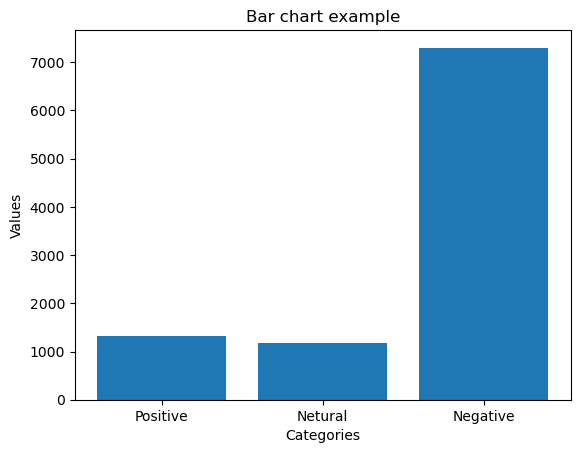

In [9]:
compound_scores = []
for tweet_scores in all_scores:
    compound_scores.append(tweet_scores['compound'])
    
scores = np.array(compound_scores)

x = np.array(['Positive', 'Netural', 'Negative'])
y = np.array([np.sum(scores > 0), np.sum(scores == 0), np.sum(scores < 0)])

# Create bar chart
plt.bar(x, y)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar chart example')

# Show chart
plt.show()

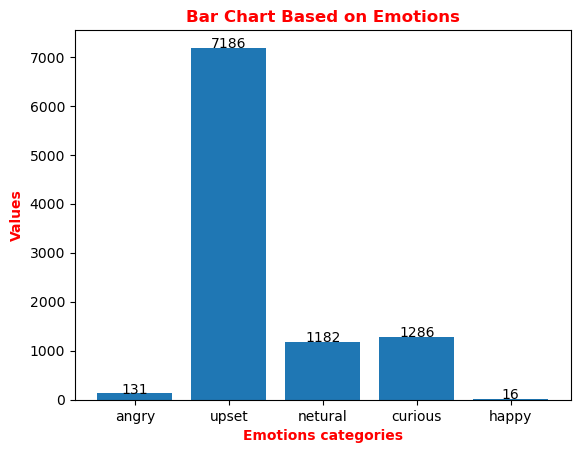

In [10]:
compound_scores = []
for tweet_scores in all_scores:
    compound_scores.append(tweet_scores['compound'])
    
scores = np.array(compound_scores)

x = np.array([emotion for emotion in emotion_dict.keys()])
y = np.array([emotion[1] for emotion in emotion_dict.items()])

# Create bar chart
plt.bar(x, y)

# Write the number of each bar above it
for i, v in enumerate(y):
    plt.text(i, v + 0.2, str(v), ha='center')

# Add labels and title
plt.xlabel('Emotions categories', fontweight="bold", color="red")
plt.ylabel('Values', fontweight="bold", color="red")
plt.title('Bar Chart Based on Emotions', fontweight="bold", color="red")

# Show chart
plt.show()


In [11]:
STOP_WORDS = stopwords.words()

# removing the emojies
# https://www.kaggle.com/alankritamishra/covid-19-tweet-sentiment-analysis#Sentiment-analysis
EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)


def cleaning(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    text = EMOJI_PATTERN.sub(r'', text)

    # removing the stop-words
    text_tokens = word_tokenize(text)
    tokens_without_sw = [
        word for word in text_tokens if not word in STOP_WORDS]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence

    return text

max_rows = 1000

dt = data['text'].apply(cleaning)

word_count = Counter(" ".join(dt).split()).most_common(10)
word_frequency = pd.DataFrame(word_count, columns = ['tag word', 'Frequency'])
print('tags frequency:')
word_frequency

tags frequency:


,tag word,Frequency
0,constance,8479
1,marten,7414
2,baby,7402
3,mark,5635
4,gordon,5219
5,police,4035
6,missing,3424
7,found,3409
8,arrested,2702
9,search,2644


In [12]:
data.sort_values(by='followers', ascending=False)[['username', 'followers']].drop_duplicates(subset='username').head(20)

,username,followers
4018,cnnbrk,64195142
4068,CNN,61267702
2797,BBCBreaking,51682355
947,BBCWorld,39609526
5450,BBCNews,15060185
4066,cnni,14473199
7978,HuffPost,11204819
9730,guardian,10895482
8140,CBSNews,8918937
9455,SkyNews,8371899


In [7]:
locations = data.drop_duplicates(subset='username')['location']

processed_locations = []
for location in locations:
    if type(location) == str:
        location = location.split(', ')
        processed_locations.append(location)
        
country_counter = {}

# get all countries
all_countries = list(pycountry.countries)


for country in all_countries:
    country_counter[country.name] = 0

else:
    country_counter['Unknown'] = 0
    

for country in all_countries:
    for item in processed_locations:
        if country.name in item:
            country_counter[country.name] += 1
        elif country.alpha_2 in item:
            country_counter[country.name] += 1
        elif country.alpha_3 in item:
            country_counter[country.name] += 1
        elif country.flag in item:
            country_counter[country.name] += 1
            
sorted_countries = dict(sorted(country_counter.items(), key=lambda x: x[1], reverse=True))



In [8]:
dict_for_drawing_chart = {}

# set the threshold value
threshold = 10

for country in sorted_countries.items():
    if country[1] > threshold:
        dict_for_drawing_chart[country[0]] = country[1]


# sum the values less than the threshold
total = sum(value for value in sorted_countries.values() if value < threshold)

dict_for_drawing_chart['Others'] = total

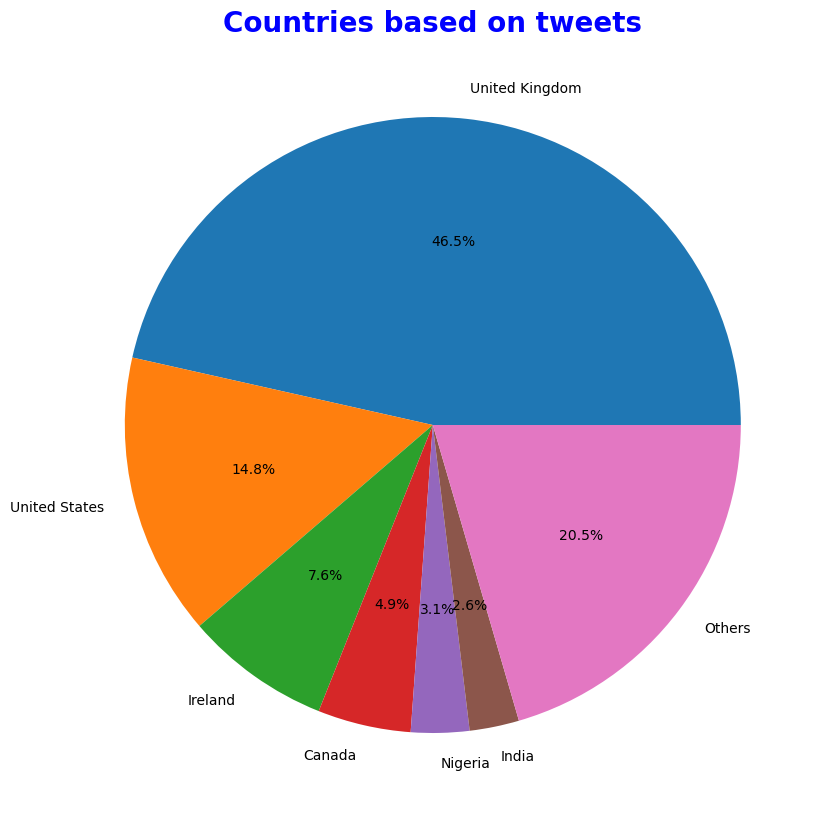

In [29]:
import math
# data for the pie chart


summation = sum(value for value in dict_for_drawing_chart.values())





labels = np.array([country[0] for country in dict_for_drawing_chart.items()])

sizes = np.array([country[1] for country in dict_for_drawing_chart.items()])



# Create a pie chart
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.title('Countries based on tweets', fontweight="bold", color="blue", fontsize=20)

# display the chart
plt.show()

In [16]:
locations = data.drop_duplicates(subset='username')['location']

processed_locations = []
for location in locations:
    if type(location) == str:
        location = location.split(', ')
        processed_locations.append(location)
        
country_counter = {}

# get all countries
all_countries = list(pycountry.countries)


for country in all_countries:
    if country.name == 'United Kingdom':
        GB = country
        
GB_tweets = []
        
for item in processed_locations:
    if GB.name in item:
        GB_tweets.append(item)
    elif GB.alpha_2 in item:
        GB_tweets.append(item)
    elif GB.alpha_3 in item:
        GB_tweets.append(item)
    elif GB.flag in item:
        GB_tweets.append(item)
        


In [17]:
GB_names = [GB.name, GB.alpha_2, GB.alpha_3, GB.flag]
unknown_city = 0
cities ={}
for items in GB_tweets:
    for item in items:
        if item in GB_names:
            items.remove(item)
        if len(items) == 0:
            unknown_city += 1
        else:
            if items[0] in cities.keys():
                cities[items[0]] += 1
            else:
                cities[items[0]] = 1
                


In [18]:
cities = dict(sorted(cities.items(), key=lambda x: x[1], reverse=True))
cities['Unknown'] = unknown_city
cities

{'England': 224,
 'Scotland': 46,
 'Wales': 24,
 'London': 12,
 'Northern Ireland': 4,
 'East Kilbride': 2,
 'Belfast': 2,
 'Surrey': 2,
 'Southsea': 2,
 'Manchester': 2,
 'Northampton': 2,
 'Derbyshire': 2,
 'Salford': 2,
 'Kent,England': 2,
 'West Sussex': 2,
 'Oxford': 2,
 'Africa': 1,
 'Hertfordshire': 1,
 'Unknown': 136}